In [1]:
# %load_ext autoreload
# %autoreload 2

In [1]:
from __future__ import print_function, division

import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
from torchmetrics.classification import Accuracy
from sklearn.metrics import confusion_matrix
import plotly.graph_objs as go

import sys
sys.path.append('../')

from modules.helpers import *
from modules.datasets import *
from modules.train_utils import train_model
from modules.dataloaders import *
from modules.test_utils import test_model

### Initialize wandb and load model

In [2]:
path = "/n/home12/ramith/FYP/bacteria-classification/results/Strain Classification - Resnet 181645133846.9762254/latest_model_epoch-7.pth"
saved = torch.load(path)
cfg   = saved['cfg']

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_c = cfg['n_classes']

class_names = [x for x in range(0, n_c)]

if(n_c == 21):
    class_names = ['Acinetobacter','B subtilis','E. coli K12','S. aureus','E. coli (CCUG17620)','E. coli (NCTC13441)','E. coli (A2-39)','K. pneumoniae (A2-23)','S. aureus (CCUG35600)','E. coli (101)','E. coli (102)','E. coli (104)','K. pneumoniae (210)','K. pneumoniae (211)','K. pneumoniae (212)','K. pneumoniae (240)','Acinetobacter K12-21','Acinetobacter K48-42','Acinetobacter K55-13','Acinetobacter K57-06','Acinetobacter K71-71']
elif(n_c == 5):
    class_names = ['Acinetobacter', 'B. subtilis', 'E. coli', 'K. pneumoniae', 'S. aureus']


In [4]:
cfg

{'learning_rate': 0.01,
 'epochs': 15,
 'pretrained_resnet': True,
 'img_size': 224,
 'n_classes': 21,
 'label_type': 'class',
 'balanced_mode': False,
 'expand_channels': True,
 'dataset_sizes': {'train': 375424, 'val': 48544, 'test': 48768}}

In [5]:
model_ft = models.resnet18(pretrained=cfg['pretrained_resnet'])

num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, n_c)

model_ft = model_ft.to(device)

In [6]:
model = model_ft
model.load_state_dict(saved['state_dict']);
model.eval();

### Initialize Class Specific Dataloaders

In [8]:
data_dir = '/n/holyscratch01/wadduwage_lab/D2NN_QPM_classification/datasets/bacteria/'

In [9]:
dataloaders = {}

N = 63
_, _, _, _ =  get_bacteria_dataloaders(cfg['img_size'], N , 10, label_type = cfg['label_type'], balanced_mode = False, expand_channels = cfg['expand_channels'])

dataset_sizes = {'test':0}

for i in range(0, 21):
    print("=====")
    dataloaders[str(i)], count =  get_bacteria_eval_dataloaders(cfg['img_size'], N , 10, label_type = cfg['label_type'] ,expand_channels = cfg['expand_channels'], isolate_class = i)

    dataset_sizes['test'] += count['test']

Dataset type train label type: class -> Loaded 375443 images
Dataset type val label type: class -> Loaded 48562 images
Dataset type test label type: class -> Loaded 48790 images
=====
Dataset type test; dataloader will have label type: class -> All files = 48790
Loaded 1561 images only from class 0
=====
Dataset type test; dataloader will have label type: class -> All files = 48790
Loaded 1404 images only from class 1
=====
Dataset type test; dataloader will have label type: class -> All files = 48790
Loaded 1668 images only from class 2
=====
Dataset type test; dataloader will have label type: class -> All files = 48790
Loaded 1937 images only from class 3
=====
Dataset type test; dataloader will have label type: class -> All files = 48790
Loaded 3114 images only from class 4
=====
Dataset type test; dataloader will have label type: class -> All files = 48790
Loaded 1396 images only from class 5
=====
Dataset type test; dataloader will have label type: class -> All files = 48790
Loade

In [10]:
# dataloaders = {}

# N = 31
# _, _, _, dataset_sizes =  get_bacteria_dataloaders(cfg['img_size'], N , 10, label_type = cfg['label_type'], balanced_mode = False, expand_channels = cfg['expand_channels'])


# for i in range(0, cfg['n_classes']):
#     print("=====")
#     dataloaders[str(i)], _ =  get_bacteria_eval_dataloaders(cfg['img_size'], N , 10, label_type = cfg['label_type'] ,expand_channels = cfg['expand_channels'], isolate_class = i)


In [11]:
# dataset_sizes['test'] = dataset_sizes['test']/N

In [12]:
# for inputs, labels in dataloaders["1"]:
#     print(".", end = '')

#     inputs = inputs.to(device,dtype=torch.float)
#     labels = labels.to(device)

#     outputs = model(inputs)
#     _, preds = torch.max(outputs, 1)
    
#     print(preds)
#     print(torch.mode(preds,0)[0])
#     print(torch.mode(labels,0)[0])
    
#     break

In [10]:
criterion = nn.CrossEntropyLoss()

In [11]:
dataset_sizes

{'test': 765}

In [12]:
# from modules.test_utils import *

In [16]:
from modules.test_utils import test_model_in_groups

In [17]:
mat, outs = test_model_in_groups(model_ft, [dataloaders, dataset_sizes, class_names] , criterion, n_classes = cfg['n_classes'] , device = device, cfg = cfg)

starting group testing..
 dataloader has 21 classes to be evaluated
New strain batch eval - 0
New strain batch eval - 1
New strain batch eval - 2
New strain batch eval - 3
New strain batch eval - 4
New strain batch eval - 5
New strain batch eval - 6
New strain batch eval - 7
New strain batch eval - 8
New strain batch eval - 9
New strain batch eval - 10
New strain batch eval - 11
New strain batch eval - 12
New strain batch eval - 13
New strain batch eval - 14
New strain batch eval - 15
New strain batch eval - 16
New strain batch eval - 17
New strain batch eval - 18
New strain batch eval - 19
New strain batch eval - 20
test Loss: 1.1753 Acc: 0.6353
[0.7155669331550598, 0.69017094373703, 0.7739807963371277, 0.7289623022079468, 0.7899807095527649, 0.4383954107761383, 0.27684730291366577, 0.6109191179275513, 0.8558838963508606, 0.5274004936218262, 0.3209232985973358, 0.5983606576919556, 0.7608383297920227, 0.6983705759048462, 0.6501534581184387, 0.6790784001350403, 0.7817851305007935, 0.592

## Save classwise probabilities

In [18]:
# outs[0]

In [19]:
outs_s  = {}
means = []
big_lis = []

for i in range(0,21):
    # outs_s[i] = torch.tensor(outs[i]).reshape(len(outs[i]),21)
    outs_s[str(i)] = np.array(outs[i],dtype=np.object).reshape(len(outs[i]),21)
    
    means.append(np.mean(outs_s[str(i)],0))
    
    big_lis.append(outs_s[str(i)])

In [20]:
# temp = np.array(big_lis,dtype=object)

In [ ]:
out

In [21]:
means

[array([0.6675395620638411, 0.0745226566663331, 0.0050912285581597855,
        0.0022608217079138336, 0.03457464901221555, 0.014493651216408138,
        0.02504247331450218, 0.0026884816721032484, 7.826603944759379e-05,
        0.018461928671474313, 0.03184108079106349, 0.004947474914061234,
        0.03695226778809237, 0.005675255459805772, 0.006420975486168815,
        0.02733281933452789, 0.008697832061502247, 0.003953663640572444,
        0.019034597799152213, 0.005936261991218111, 0.0044540571453543475],
       dtype=object),
 array([0.06725526322251427, 0.6468160450925592, 0.027305006272059482,
        0.0027622886726559916, 0.01990457031980858, 0.003968626579750135,
        0.012681144191513803, 0.020596877813490618, 0.0001800916989536958,
        0.013658904388194221, 0.04375637614327508, 0.015359488076314773,
        0.007262100163396623, 0.015143905698893437, 0.020583627101876598,
        0.013307954827764663, 0.04657173736852645, 0.0033448411776094583,
        0.009153120976

In [22]:
# means

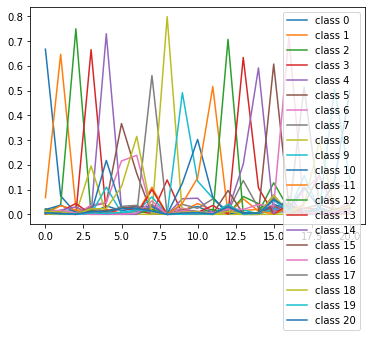

In [30]:
plt.figure()
for i in range(0,21):
    plt.plot(means[i],label=f"class {i}")
plt.legend(loc="best")

In [24]:
# plt.plot(softmax(k))

#### saving

In [25]:
from scipy.io import savemat
from numpy import *


In [26]:
savemat('prob.mat', {'probabilities': big_lis})


/n/home12/ramith/.conda/envs/fyp_env/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [27]:
#oru

In [51]:
_class = 15

In [52]:
o = np.argmax(outs_s[str(_class)],axis=1)

In [53]:
np.sum([o==_class])


3301

In [54]:
np.sum([o==_class])/outs_s[str(_class)].shape[0]

0.6790783789343756

In [ ]:
class_names

## Occlusion Sensitivity Analysis 

In [17]:
from captum.attr import Occlusion
from captum.attr import visualization as viz

model  = model.to('cpu')
occlusion = Occlusion(model)


class = tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
class_name = Acinetobacter


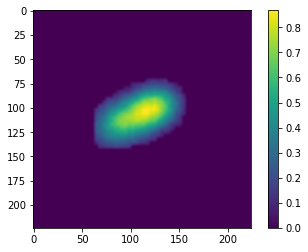

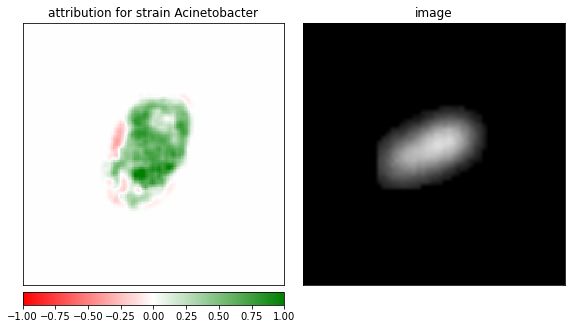

class = tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
class_name = B subtilis


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


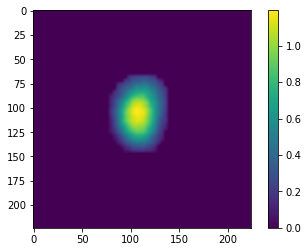

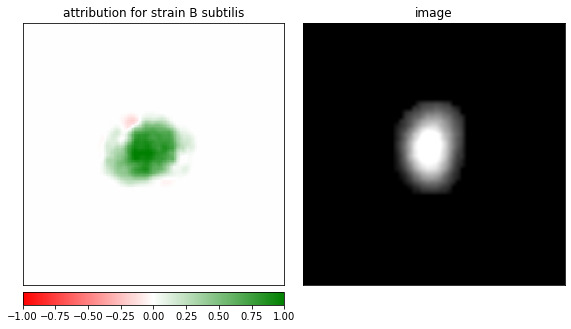

class = tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
class_name = E. coli K12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


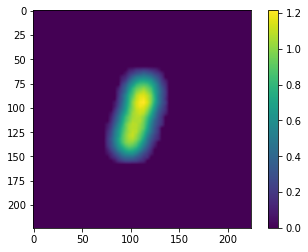

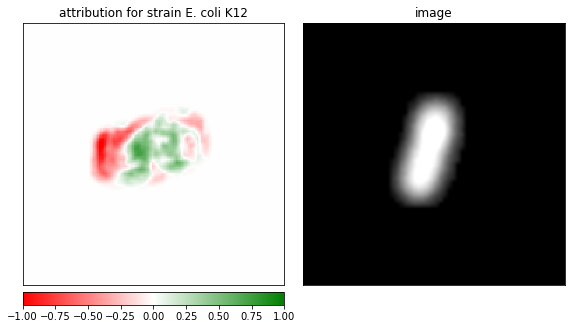

class = tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])
class_name = S. aureus


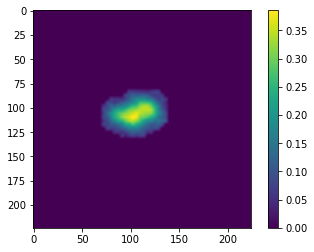

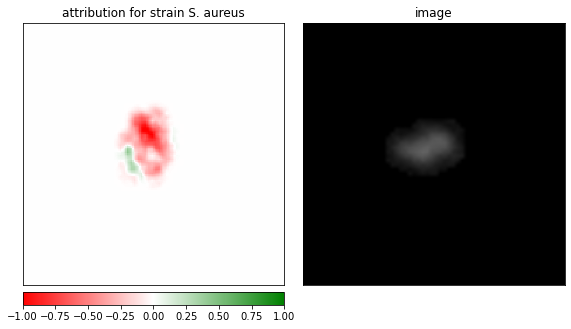

class = tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
class_name = E. coli (CCUG17620)


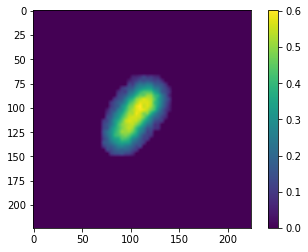

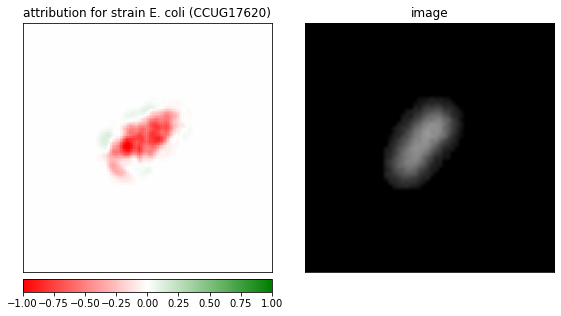

class = tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])
class_name = E. coli (NCTC13441)


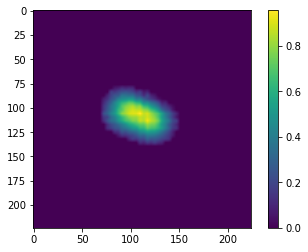

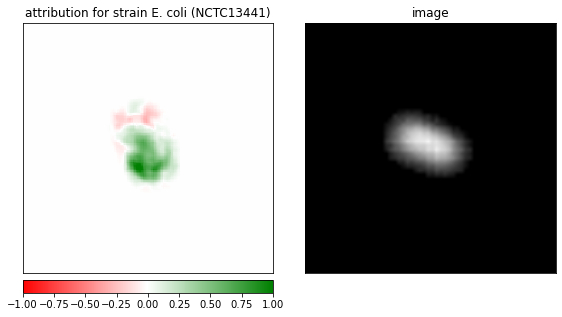

class = tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])
class_name = E. coli (A2-39)


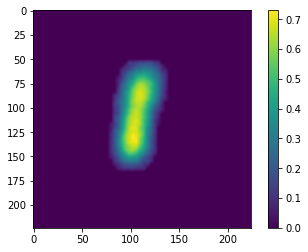

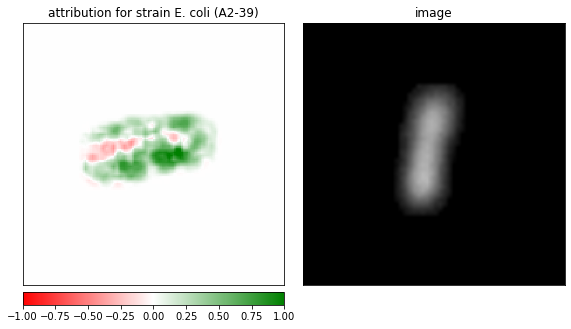

class = tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])
class_name = K. pneumoniae (A2-23)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


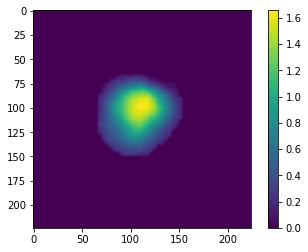

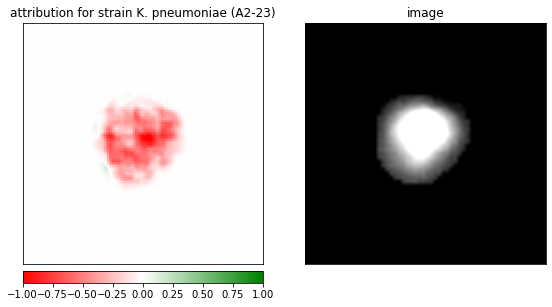

class = tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
class_name = S. aureus (CCUG35600)


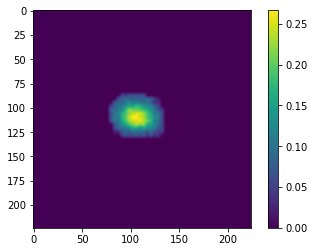

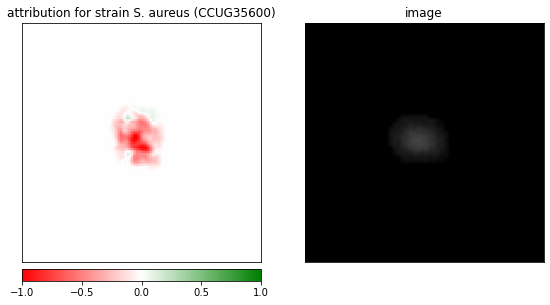

class = tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])
class_name = E. coli (101)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


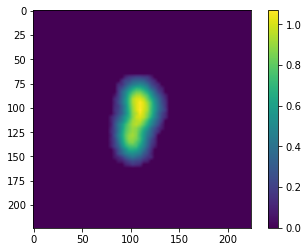

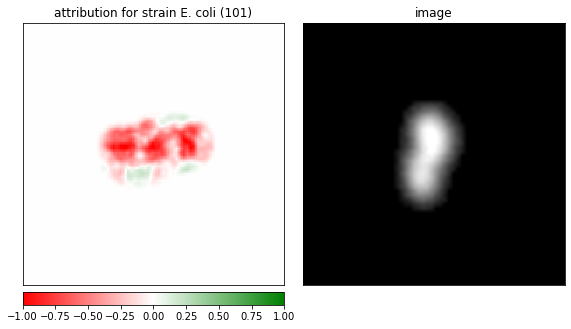

class = tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10])
class_name = E. coli (102)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


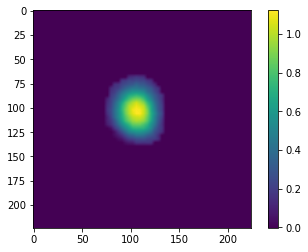

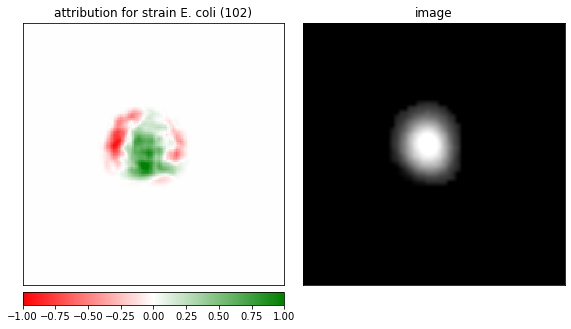

class = tensor([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11])
class_name = E. coli (104)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


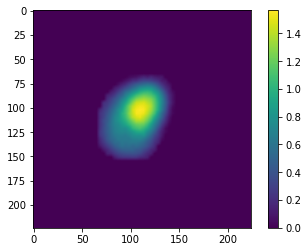

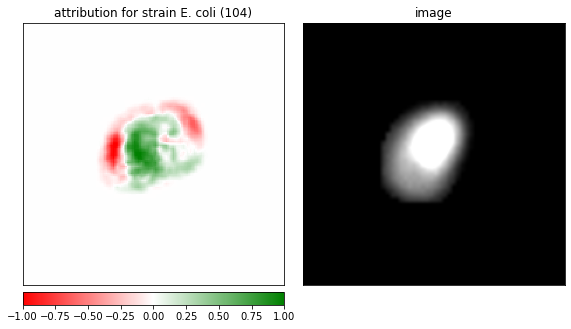

class = tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12])
class_name = K. pneumoniae (210)


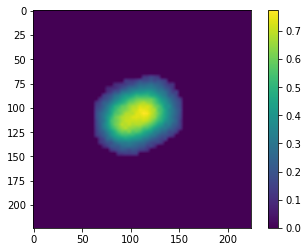

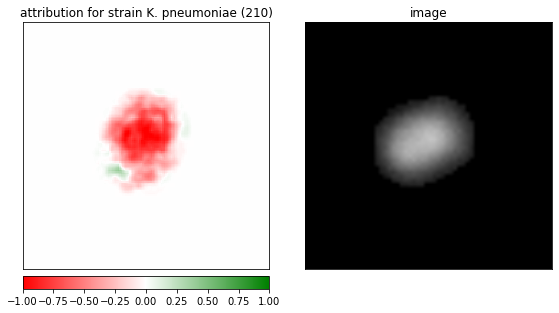

class = tensor([13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13])
class_name = K. pneumoniae (211)


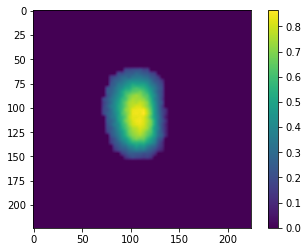

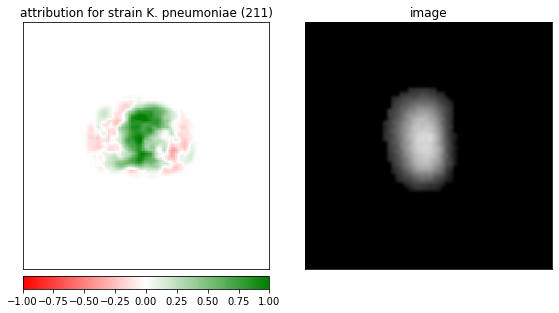

class = tensor([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14])
class_name = K. pneumoniae (212)


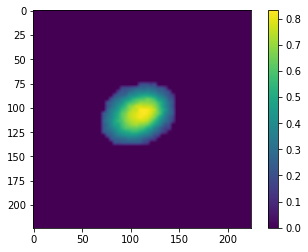

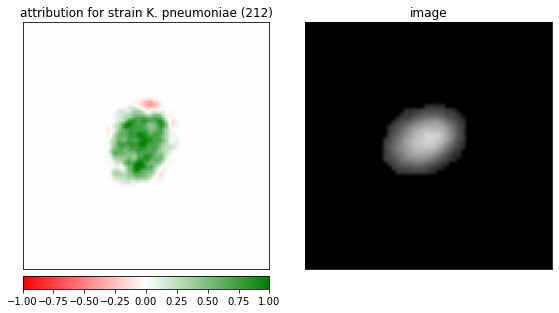

class = tensor([15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15])
class_name = K. pneumoniae (240)


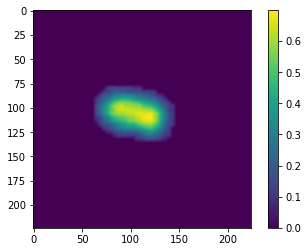

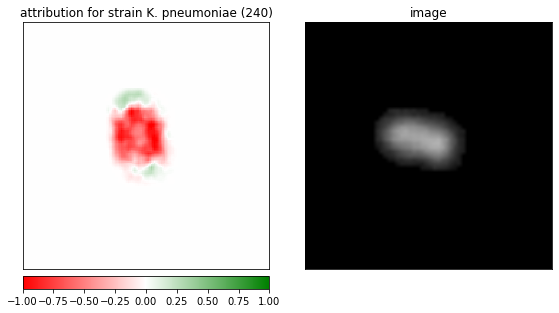

class = tensor([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16])
class_name = Acinetobacter K12-21


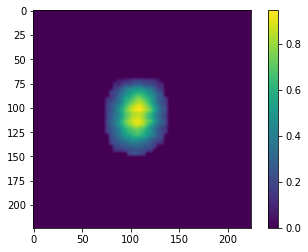

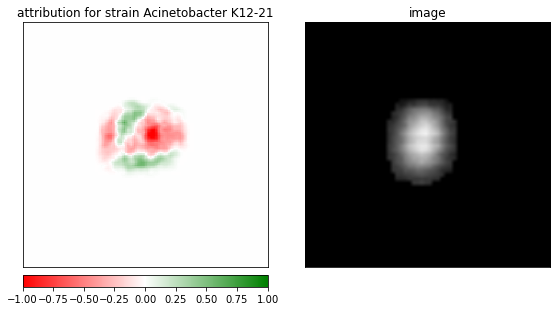

class = tensor([17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17])
class_name = Acinetobacter K48-42


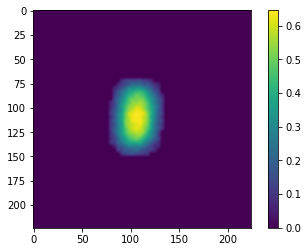

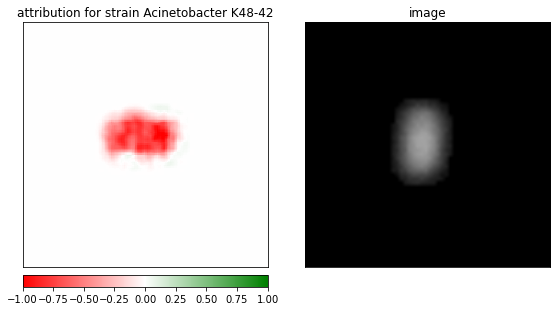

class = tensor([18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18])
class_name = Acinetobacter K55-13


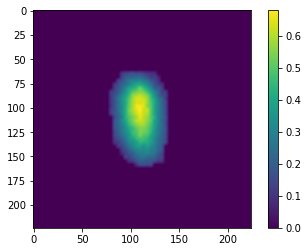

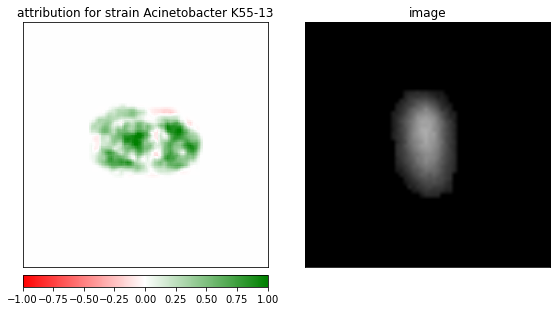

class = tensor([19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 19, 19, 19, 19, 19])
class_name = Acinetobacter K57-06


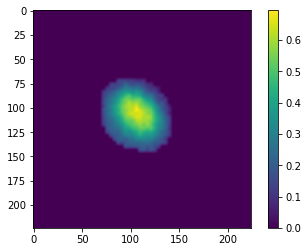

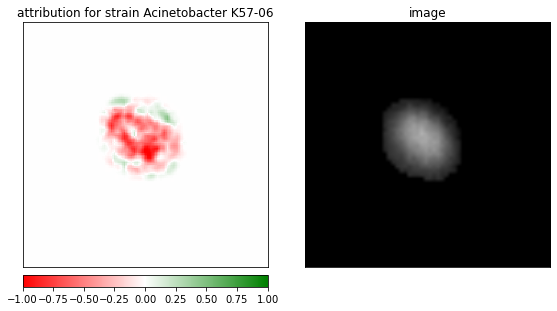

class = tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20])
class_name = Acinetobacter K71-71


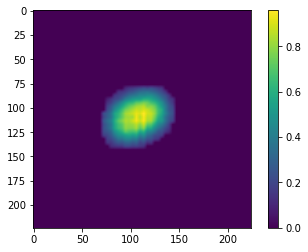

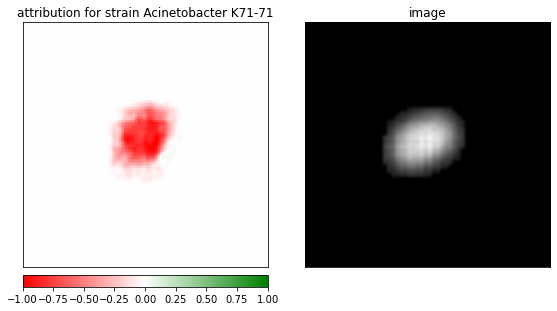

In [18]:
for i in range(0,21):
    
    h = iter(dataloaders[str(i)])
    data =  next(h)

    input_img = data[0][0].unsqueeze(0)

    print(f"class = {data[1]}")
    print(f"class_name = {class_names[i]}")
    input_img = input_img.to('cpu', dtype=torch.float)

    plt.imshow(input_img[0].T[:,:,0])
    plt.colorbar()
    
    strides = (3, 3, 3)               # smaller = more fine-grained attribution but slower
    target=1,                         # Antibiotic resistant
    sliding_window_shapes=(3, 5, 5)  # choose size enough to change object appearance
    baselines = 0                     # values to occlude the image with. 0 corresponds to gray

    attribution_non_res = occlusion.attribute(input_img,
                                           strides = strides,
                                           target=target,
                                           sliding_window_shapes=sliding_window_shapes,
                                           baselines=baselines)

    img = input_img[0].T.cpu().numpy()

    attribution_non_res = np.transpose(attribution_non_res.squeeze().cpu().detach().numpy(), (1,2,0))

    vis_types = ["heat_map", "original_image"]
    vis_signs = ["all", "all"] # "positive", "negative", or "all" to show both
    # positive attribution indicates that the presence of the area increases the prediction score
    # negative attribution indicates distractor areas whose absence increases the score

    _ = viz.visualize_image_attr_multiple(attribution_non_res,
                                          img,
                                          vis_types,
                                          vis_signs,
                                          [f"attribution for strain {class_names[i]}", "image"],
                                          show_colorbar = True
                                         )